[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rmartimarly/ImageRegistrationTutorial/blob/main/1Intro_image_registration.ipynb)

# Tutorial on Intensity Based registration

Robert Martí robert.marti@udg.edu
University of Girona



A radiologist comes to your office and asks to help him for a very complicated problem: he has two images of the same patient and wants to find the changes the had happened in the two images: lesions, etc.

![Fixed](https://raw.githubusercontent.com/rmartimarly/ImageRegistrationTutorial/main/files/brain1.png "Fixed")
![Moving](https://raw.githubusercontent.com/rmartimarly/ImageRegistrationTutorial/main/files/brain2_lesion.png "Moving")


Could we measure how similar are two images?

### Import libraries

In [1]:
# !pip install numpy
# !pip install opencv-python
# !pip install pyplot



In [5]:
import numpy as np
import cv2

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.utils import get_file
import os

### Loading images

In [6]:
import os
from tensorflow.keras.utils import get_file

# Import medical data - we are going to use the head and neck CT data to show the losses.
main_path = os.getcwd()

data_path = "files"
file_path1 = os.path.abspath(os.path.join(main_path, data_path, "brain1.png"))
origin1 = "https://raw.githubusercontent.com/rmartimarly/ImageRegistrationTutorial/main/files/brain1.png"
file_path2 = os.path.abspath(os.path.join(main_path, data_path, "brain2_lesion.png"))
origin2 = "https://raw.githubusercontent.com/rmartimarly/ImageRegistrationTutorial/main/files/brain2_lesion.png"

# Create the directory if it doesn't exist
if not os.path.exists(data_path):
    os.makedirs(data_path)

# Remove existing files
if os.path.exists(file_path1):
    os.remove(file_path1)
if os.path.exists(file_path2):
    os.remove(file_path2)

# Updated `get_file()` calls
get_file(fname="brain1.png", origin=origin1, cache_dir=main_path, cache_subdir=data_path)
get_file(fname="brain2_lesion.png", origin=origin2, cache_dir=main_path, cache_subdir=data_path)


68075/68075 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
64955/64955 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'/content/files/brain2_lesion.png'

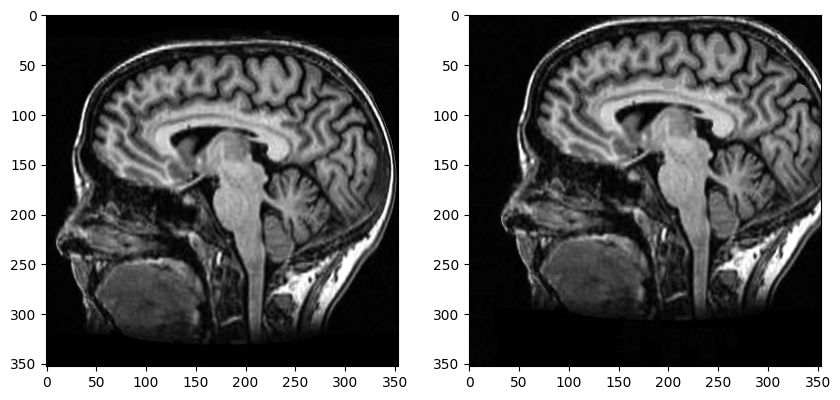

In [7]:
# Load both images
img_ref = cv2.imread(file_path1, 0)
img_tar= cv2.imread(file_path2,0)
f = plt.figure(figsize = (10,200))
f.add_subplot(1,2, 1)
plt.imshow(img_ref, cmap='gray')
f.add_subplot(1,2, 2)
plt.imshow(img_tar, cmap='gray')
plt.show(block=True)



### Smooth images a bit (works better!)

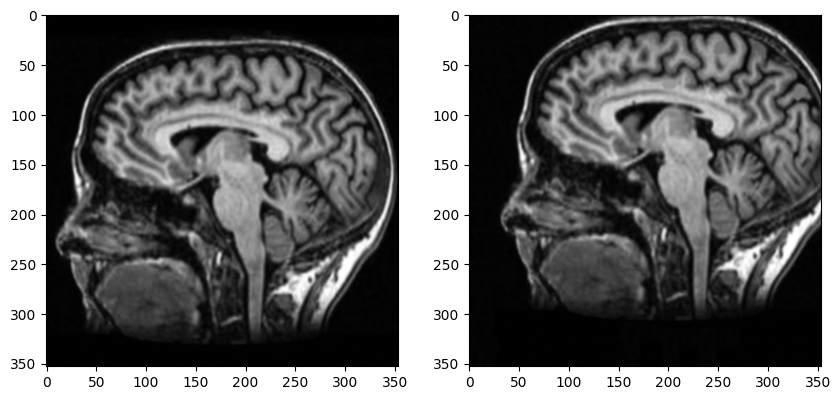

In [8]:
# smoothing imges
kernel = np.ones((3,3),np.float32)/9
img_ref_s = cv2.filter2D(img_ref,-1,kernel)
img_tar_s = cv2.filter2D(img_tar,-1,kernel)

f = plt.figure(figsize = (10,200))
f.add_subplot(1,2, 1)
plt.imshow(img_ref_s, cmap='gray')
f.add_subplot(1,2, 2)
plt.imshow(img_tar_s, cmap='gray')
plt.show(block=True)

### Can we measure the similarity between two images?


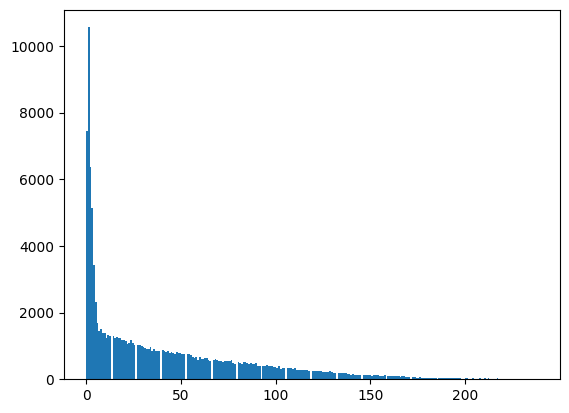

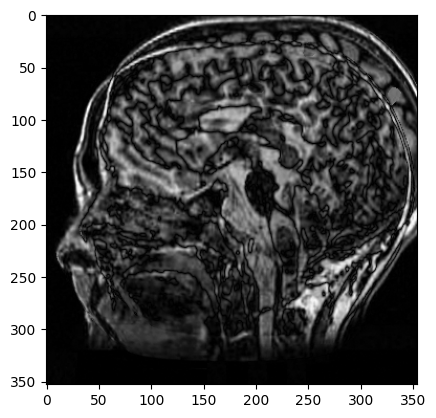

42.28577487556217
0.0
8.997919571612742


In [9]:
rms = np.abs(img_ref.astype(float)-img_tar.astype(float))
# histogram, bin_edges = np.histogram(rms, bins=256)
# plt.plot(rms)

plt.hist(rms.flatten(), bins=256)
plt.show()
plt.imshow(rms, cmap='gray')
plt.show()

print(np.sum(rms)/img_ref.size)

rms = abs(img_ref-img_ref)
print(np.sum(rms)/img_ref.size)

rms = abs((img_ref-img_tar)**2)
print(np.sqrt(np.sum(rms)/img_ref.size))



### Let's put this into a function

In [ ]:
def error_rms (im1, im2):
    rms = abs((im1.astype(float)-im2.astype(float))**2)
    rms = np.sqrt(np.sum(rms)/im1.size)
    return rms


In [ ]:
print (error_rms (img_ref, img_tar))
print (error_rms (img_ref_s, img_tar_s))


61.76674431871843
59.003760141944426


### Transform an Image: translation only.


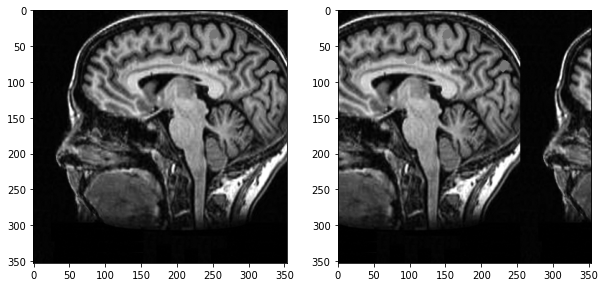

In [ ]:
img_tarM = np.roll(img_tar,-100 , axis=1)
f = plt.figure(figsize = (10,200))
f.add_subplot(1,2, 1)
plt.imshow(img_tar, cmap='gray')
f.add_subplot(1,2, 2)
plt.imshow(img_tarM, cmap='gray')
plt.show(block=True)

### All together: error as a function of the translation parameters

First we translate the moving image and then compute the error.

In [ ]:
def funcio_error(img_r,img_m,params):
#     print (np.round(params.astype(int),0))

    img_tarM = np.roll(img_m,np.round(params).astype(int), axis=(0,1))
    error = error_rms(img_tarM,img_r) # error actual
    return error


### Let's plot the parameter space

In [ ]:
xaxis = np.linspace(0, 50, 51, dtype=int)
yaxis = np.linspace(-50, 0, 51,dtype=int)
zval = np.zeros([len(xaxis),len(yaxis)])
X, Y = np.meshgrid(xaxis, yaxis)

In [ ]:
params = np.zeros(2)
for i in range(len(X)):
    for j in range(len(Y)):
        params[0] = X[i,j]
        params[1] = Y[i,j]
        zval[i,j] = funcio_error(img_ref_s,img_tar_s, params)

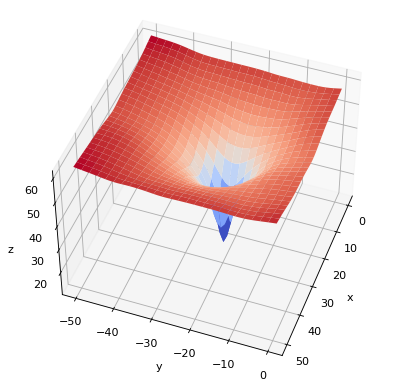

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection="3d")

# ax.plot_wireframe(X, Y,zval, color='green')
ax.plot_surface(X, Y,zval, cmap=cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.view_init(120, 30)
ax.view_init(45, 20)

plt.show()


### Register!
Find the best parameters (translation) that minimise the error.




--> 0 - params [0. 0.]
	Err_act (metric):  59.003760141944426 Error wrt params:  [58.88451312 59.29252404]
	Gradient:  [-0.11924702  0.2887639 ] Step_size  0.0433145852166831 0.0433145852166831
--> 1 - params [ 0.01788705 -0.04331459]
	Err_act (metric):  59.003760141944426 Error wrt params:  [58.88451312 59.29252404]
	Gradient:  [-0.11924702  0.2887639 ] Step_size  0.0433145852166831 0.0433145852166831
--> 2 - params [ 0.03577411 -0.08662917]
	Err_act (metric):  59.003760141944426 Error wrt params:  [58.88451312 59.29252404]
	Gradient:  [-0.11924702  0.2887639 ] Step_size  0.04331458521668309 0.04331458521668309
--> 3 - params [ 0.05366116 -0.12994376]
	Err_act (metric):  59.003760141944426 Error wrt params:  [58.88451312 59.29252404]
	Gradient:  [-0.11924702  0.2887639 ] Step_size  0.043314585216683105 0.043314585216683105
--> 4 - params [ 0.07154821 -0.17325834]
	Err_act (metric):  59.003760141944426 Error wrt params:  [58.88451312 59.29252404]
	Gradient:  [-0.11924702  0.2887639 ] S

	Err_act (metric):  58.2574509818345 Error wrt params:  [58.12848789 58.56786125]
	Gradient:  [-0.12896309  0.31041027] Step_size  0.046561539827284726 0.046561539827284726
--> 45 - params [ 0.84579262 -2.05748122]
	Err_act (metric):  58.2574509818345 Error wrt params:  [58.12848789 58.56786125]
	Gradient:  [-0.12896309  0.31041027] Step_size  0.046561539827284726 0.046561539827284726
--> 46 - params [ 0.86513708 -2.10404276]
	Err_act (metric):  58.2574509818345 Error wrt params:  [58.12848789 58.56786125]
	Gradient:  [-0.12896309  0.31041027] Step_size  0.046561539827284726 0.046561539827284726
--> 47 - params [ 0.88448155 -2.1506043 ]
	Err_act (metric):  58.2574509818345 Error wrt params:  [58.12848789 58.56786125]
	Gradient:  [-0.12896309  0.31041027] Step_size  0.046561539827284726 0.046561539827284726
--> 48 - params [ 0.90382601 -2.19716584]
	Err_act (metric):  58.2574509818345 Error wrt params:  [58.12848789 58.56786125]
	Gradient:  [-0.12896309  0.31041027] Step_size  0.0465615

--> 93 - params [ 1.84235534 -4.08026952]
	Err_act (metric):  57.57631361675101 Error wrt params:  [57.43311549 57.83730581]
	Gradient:  [-0.14319813  0.26099219] Step_size  0.03914882826007293 0.03914882826007293
--> 94 - params [ 1.86383506 -4.11941835]
	Err_act (metric):  57.57631361675101 Error wrt params:  [57.43311549 57.83730581]
	Gradient:  [-0.14319813  0.26099219] Step_size  0.03914882826007293 0.03914882826007293
--> 95 - params [ 1.88531478 -4.15856718]
	Err_act (metric):  57.57631361675101 Error wrt params:  [57.43311549 57.83730581]
	Gradient:  [-0.14319813  0.26099219] Step_size  0.03914882826007293 0.03914882826007293
--> 96 - params [ 1.9067945 -4.197716 ]
	Err_act (metric):  57.57631361675101 Error wrt params:  [57.43311549 57.83730581]
	Gradient:  [-0.14319813  0.26099219] Step_size  0.03914882826007293 0.03914882826007293
--> 97 - params [ 1.92827422 -4.23686483]
	Err_act (metric):  57.57631361675101 Error wrt params:  [57.43311549 57.83730581]
	Gradient:  [-0.14319

	Err_act (metric):  56.91481510150168 Error wrt params:  [56.70837645 57.16644142]
	Gradient:  [-0.20643865  0.25162632] Step_size  0.037743947760567664 0.037743947760567664
--> 146 - params [ 3.23977518 -6.06789331]
	Err_act (metric):  56.91481510150168 Error wrt params:  [56.70837645 57.16644142]
	Gradient:  [-0.20643865  0.25162632] Step_size  0.037743947760567664 0.037743947760567664
--> 147 - params [ 3.27074098 -6.10563726]
	Err_act (metric):  56.91481510150168 Error wrt params:  [56.70837645 57.16644142]
	Gradient:  [-0.20643865  0.25162632] Step_size  0.037743947760567664 0.037743947760567664
--> 148 - params [ 3.30170678 -6.1433812 ]
	Err_act (metric):  56.91481510150168 Error wrt params:  [56.70837645 57.16644142]
	Gradient:  [-0.20643865  0.25162632] Step_size  0.037743947760567664 0.037743947760567664
--> 149 - params [ 3.33267258 -6.18112515]
	Err_act (metric):  56.91481510150168 Error wrt params:  [56.70837645 57.16644142]
	Gradient:  [-0.20643865  0.25162632] Step_size  

	Gradient:  [-0.26767632  0.31833485] Step_size  0.04775022802147966 0.04775022802147966
--> 196 - params [ 5.03320334 -8.22753481]
	Err_act (metric):  55.86661056270939 Error wrt params:  [55.59893425 56.18494542]
	Gradient:  [-0.26767632  0.31833485] Step_size  0.04775022802147966 0.04775022802147966
--> 197 - params [ 5.07335479 -8.27528503]
	Err_act (metric):  55.86661056270939 Error wrt params:  [55.59893425 56.18494542]
	Gradient:  [-0.26767632  0.31833485] Step_size  0.04775022802147966 0.04775022802147966
--> 198 - params [ 5.11350624 -8.32303526]
	Err_act (metric):  55.86661056270939 Error wrt params:  [55.59893425 56.18494542]
	Gradient:  [-0.26767632  0.31833485] Step_size  0.04775022802147966 0.04775022802147966
--> 199 - params [ 5.15365769 -8.37078549]
	Err_act (metric):  55.86661056270939 Error wrt params:  [55.59893425 56.18494542]
	Gradient:  [-0.26767632  0.31833485] Step_size  0.04775022802147966 0.04775022802147966
--> 200 - params [ 5.19380913 -8.41853572]
	Err_act

	Err_act (metric):  54.580588237450804 Error wrt params:  [54.2042396  54.94520587]
	Gradient:  [-0.37634864  0.36461764] Step_size  0.056452296086353826 0.056452296086353826
--> 242 - params [  7.34258981 -10.53804235]
	Err_act (metric):  54.284445907870584 Error wrt params:  [53.82946213 54.58058824]
	Gradient:  [-0.45498377  0.29614233] Step_size  0.06824756593240089 0.06824756593240089
--> 243 - params [  7.41083738 -10.5824637 ]
	Err_act (metric):  54.284445907870584 Error wrt params:  [53.82946213 54.58058824]
	Gradient:  [-0.45498377  0.29614233] Step_size  0.06824756593240089 0.06824756593240089
--> 244 - params [  7.47908495 -10.62688505]
	Err_act (metric):  54.284445907870584 Error wrt params:  [53.82946213 54.58058824]
	Gradient:  [-0.45498377  0.29614233] Step_size  0.06824756593240089 0.06824756593240089
--> 245 - params [  7.54733251 -10.6713064 ]
	Err_act (metric):  53.829462134987914 Error wrt params:  [53.36356123 54.2042396 ]
	Gradient:  [-0.4659009   0.37477746] Step

	Err_act (metric):  51.45375069411354 Error wrt params:  [50.82803396 51.87735945]
	Gradient:  [-0.62571673  0.42360875] Step_size  0.09385750948514548 0.09385750948514548
--> 291 - params [ 11.34151775 -13.35759505]
	Err_act (metric):  51.45375069411354 Error wrt params:  [50.82803396 51.87735945]
	Gradient:  [-0.62571673  0.42360875] Step_size  0.09385750948514548 0.09385750948514548
--> 292 - params [ 11.43537525 -13.42113636]
	Err_act (metric):  51.45375069411354 Error wrt params:  [50.82803396 51.87735945]
	Gradient:  [-0.62571673  0.42360875] Step_size  0.09385750948514548 0.09385750948514548
--> 293 - params [ 11.52923276 -13.48467768]
	Err_act (metric):  50.82803396421257 Error wrt params:  [50.20987219 51.31892244]
	Gradient:  [-0.61816177  0.49088847] Step_size  0.09272426588007576 0.09272426588007576
--> 294 - params [ 11.62195703 -13.55831095]
	Err_act (metric):  50.414814317468334 Error wrt params:  [49.70669039 50.82803396]
	Gradient:  [-0.70812393  0.41321965] Step_size 

	Err_act (metric):  41.46940366436253 Error wrt params:  [39.57679029 42.61894689]
	Gradient:  [-1.89261337  1.14954322] Step_size  0.2838920055296228 0.2838920055296228
--> 340 - params [ 18.21487195 -17.87934688]
	Err_act (metric):  41.46940366436253 Error wrt params:  [39.57679029 42.61894689]
	Gradient:  [-1.89261337  1.14954322] Step_size  0.2838920055296228 0.2838920055296228
--> 341 - params [ 18.49876395 -18.05177836]
	Err_act (metric):  41.46940366436253 Error wrt params:  [39.57679029 42.61894689]
	Gradient:  [-1.89261337  1.14954322] Step_size  0.2838920055296228 0.2838920055296228
--> 342 - params [ 18.78265596 -18.22420985]
	Err_act (metric):  39.57679029416504 Error wrt params:  [37.48967848 41.10764823]
	Gradient:  [-2.08711181  1.53085794] Step_size  0.3130667717886517 0.3130667717886517
--> 343 - params [ 19.09572273 -18.45383854]
	Err_act (metric):  39.57679029416504 Error wrt params:  [37.48967848 41.10764823]
	Gradient:  [-2.08711181  1.53085794] Step_size  0.313066

	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 388 - params [ 23.66183558 -22.51804524]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient:  [ 2.01848392 -3.74422993] Step_size  0.5616344894301122 0.5616344894301122
--> 389 - params [ 23.35906299 -21.95641075]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4458531296195609 0.4458531296195609
--> 390 - params [ 23.80491612 -22.31705443]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 391 - params [ 23.35784375 -22.81464001]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.471

--> 436 - params [ 23.86331552 -22.47253871]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 437 - params [ 23.41624315 -22.97012429]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 438 - params [ 23.77221496 -22.49837112]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 439 - params [ 23.32514259 -22.9959567 ]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 440 - params [ 23.6811144  -22.52420353]
	Err_act (metric):  14.9428714770631 Error wrt params:  [16.9613554  11.19864155]
	Gradient

	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 484 - params [ 23.17186996 -22.56397408]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 485 - params [ 23.52784177 -22.09222091]
	Err_act (metric):  11.198641547529014 Error wrt params:  [14.17912404 14.51587876]
	Gradient:  [2.98048249 3.31723721] Step_size  0.49758558129581587 0.49758558129581587
--> 486 - params [ 23.0807694  -22.58980649]
	Err_act (metric):  17.316016883509207 Error wrt params:  [14.94287148 14.17099574]
	Gradient:  [-2.37314541 -3.14502114] Step_size  0.4717531707774647 0.4717531707774647
--> 487 - params [ 23.43674121 -22.11805332]
	Err_act (metric):  14.170995744992764 Error wrt params:  [11.19864155 16.57528694]
	Gradient:  [-2.9723542   2.40429119] Step_size  0.4

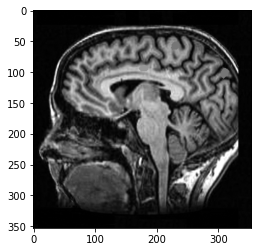

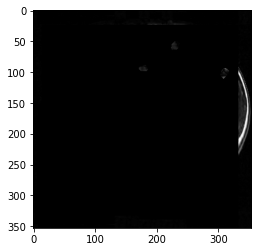

In [ ]:
import time

err = np.zeros(2)
params = np.zeros(2)

rate = 0.15 # Learning rate ??
precision = 0.000001 #This tells us when to stop the algorithm
max_iters = 500 # maximum number of iterations
iters = 0 #iteration counter
g_step = 1 # gradient step: too small more iterations are needed, too large may jump out the solution

step_size = 10

while step_size > precision and iters < max_iters:

#     if (iters > max_iters/2): rate = 0.015
    prev_params = np.copy(params)
    print("-->",iters, "- params",params)
    error_act = funcio_error(img_ref_s,img_tar_s, params)

    # Error modificant lleugerament els paràmetres
    err[0] = funcio_error(img_ref_s,img_tar_s,params+[g_step, 0])
    err[1] = funcio_error(img_ref_s,img_tar_s,params+[0, g_step])

    grad = err-error_act

    params = params - rate * grad

    new_step_size = np.max(abs(prev_params-params)) #Change in x
    step_size = new_step_size
    iters +=1 #iteration count

    print ('\tErr_act (metric): ', error_act, 'Error wrt params: ', err)
    print ('\tGradient: ', grad,"Step_size ", step_size, new_step_size)

print("The local minimum occurs at", params)
plt.show(block=True)

img_tarM = np.roll(img_tar,np.round(params).astype(int), axis=(0,1))
plt.imshow(img_tarM, cmap='gray')
plt.show()
rms = np.abs(img_ref.astype(float)-img_tarM.astype(float))


plt.imshow(rms, cmap='gray')
plt.show()



### We analyse the difference image

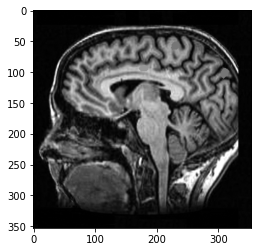

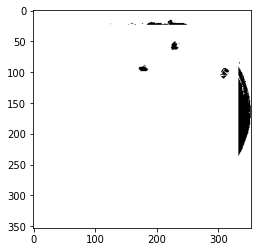

In [ ]:

img_tarM = np.roll(img_tar,np.round(params).astype(int), axis=(0,1))
plt.imshow(img_tarM, cmap='gray')
plt.show()
rms = np.abs(img_ref.astype(float)-img_tarM.astype(float))

rms = (rms>10) * 255

plt.imshow(255-rms, cmap='gray')
plt.show()
